# CNN Model for BP Estimation using PPG + ECG

## Imports and Setup


In [1]:
import sys, os, glob
sys.path.append(os.path.abspath(".."))  # go one level up (project root)

import numpy as np
import torch.nn as nn
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from dataset.utils import clean_labels, split_dataset, plot_bp_distribution
from models.cnn_bp_model import CNN_BP_Estimator

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Device config
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # for Apple Silicon (Metal Performance Shaders)
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# Performance
torch.backends.cudnn.benchmark = True   # lets cudnn choose best kernel for convs
torch.backends.cudnn.deterministic = False  # fine since we fix seeds


✅ Using device: cuda


## Load Saved Data

In [3]:
train_data = np.load("../data/processed/ppg_ecg_clean_train.npz")
X_train, y_train = train_data['X'], train_data['y']
val_data = np.load("../data/processed/ppg_ecg_clean_val.npz")
X_val, y_val = val_data['X'], val_data['y']
test_data = np.load("../data/processed/ppg_ecg_clean_test.npz")
X_test, y_test = test_data['X'], test_data['y']

print(f"✅ Loaded data: train {X_train.shape}, val {X_val.shape}, test {X_test.shape}")

# Delete loaded data to save memory
del train_data, val_data, test_data

✅ Loaded data: train (2398118, 2, 375), val (513882, 2, 375), test (513883, 2, 375)


## Prepare Data

In [4]:
# Convert to torch tensors
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train)

X_val_t = torch.tensor(X_val)
y_val_t = torch.tensor(y_val)

X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test)

print(f"Train tensor: X={X_train_t.shape}, y={y_train_t.shape}, dtype={X_train_t.dtype}")
print(f"Val tensor:   X={X_val_t.shape}, y={y_val_t.shape}, dtype={X_val_t.dtype}")
print(f"Test tensor:  X={X_test_t.shape}, y={y_test_t.shape}, dtype={X_test_t.dtype}")


Train tensor: X=torch.Size([2398118, 2, 375]), y=torch.Size([2398118, 2]), dtype=torch.float32
Val tensor:   X=torch.Size([513882, 2, 375]), y=torch.Size([513882, 2]), dtype=torch.float32
Test tensor:  X=torch.Size([513883, 2, 375]), y=torch.Size([513883, 2]), dtype=torch.float32


In [5]:
# Replace NaNs and Infs with 0s
X_train_t = torch.nan_to_num(X_train_t, nan=0.0, posinf=0.0, neginf=0.0)
X_val_t = torch.nan_to_num(X_val_t, nan=0.0, posinf=0.0, neginf=0.0)
X_test_t = torch.nan_to_num(X_test_t, nan=0.0, posinf=0.0, neginf=0.0)

In [6]:
print("After cleaning:")
print("X_train_t:", torch.isnan(X_train_t).any().item())
print("X_val_t:", torch.isnan(X_val_t).any().item())
print("X_test_t:", torch.isnan(X_test_t).any().item())
print("X_train_t min/max:", X_train_t.min().item(), X_train_t.max().item())

After cleaning:
X_train_t: False
X_val_t: False
X_test_t: False
X_train_t min/max: -7.895484447479248 6.631664752960205


In [7]:
# Create DataLoaders

batch_size=256

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
print(f"✅ Created DataLoaders with batch size {batch_size}")


✅ Created DataLoaders with batch size 256


## Create Model

In [8]:
model = CNN_BP_Estimator(input_channels=2)
model = model.to(device)
print(model)
print(f"✅ Model loaded on {device}")

CNN_BP_Estimator(
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
   

### Define optimizer and loss function

In [9]:
num_epochs = 30
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("✅ Optimizer and loss function defined.")

config = {
    "batch_size": batch_size,
    "epochs": num_epochs,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "loss": "MSELoss",
} # config dictionary - useful for logging

print(config)

✅ Optimizer and loss function defined.
{'batch_size': 256, 'epochs': 30, 'learning_rate': 0.001, 'optimizer': 'Adam', 'loss': 'MSELoss'}


Beforemoving to training, let's do a sanity check - dummy forward pass.

In [10]:
X_batch, y_batch = next(iter(train_loader))
X_batch, y_batch = X_batch.to(device), y_batch.to(device)

preds = model(X_batch)
loss = criterion(preds, y_batch)
loss.backward()

print("✅ Forward + backward pass succeeded.")
print(f"Sample loss: {loss.item():.4f}")

✅ Forward + backward pass succeeded.
Sample loss: 10601.3750


Let's also define a rmse function to use as a metric.

In [11]:
def rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))

## Training Loop

In [13]:
# Make sure checkpoint directory exists
ckpt_dir = "../checkpoints"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    print(f"Created checkpoint directory at {ckpt_dir}")
else:
    print(f"Checkpoint directory exists at {ckpt_dir}")

Checkpoint directory exists at ../checkpoints


In [14]:
best_val_loss = float("inf")

# Track losses for plotting later
train_losses = []
val_losses = []
sbp_rmses = []
dbp_rmses = []

for epoch in range(num_epochs):
    # ------------------------
    # 🔹 TRAINING PHASE
    # ------------------------
    model.train()
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for X_batch, y_batch in train_bar:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_bar.set_postfix({"Batch Loss": loss.item()})

    avg_train_loss = train_loss / len(train_loader.dataset)

    # ------------------------
    # 🔹 VALIDATION PHASE
    # ------------------------
    model.eval()
    val_loss = 0.0
    sbp_rmse_total, dbp_rmse_total = 0.0, 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for X_batch, y_batch in val_bar:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            val_loss += loss.item() * X_batch.size(0)

            # Compute SBP and DBP RMSE for each batch
            sbp_rmse = rmse(preds[:, 0], y_batch[:, 0])
            dbp_rmse = rmse(preds[:, 1], y_batch[:, 1])
            sbp_rmse_total += sbp_rmse.item() * X_batch.size(0)
            dbp_rmse_total += dbp_rmse.item() * X_batch.size(0)

            val_bar.set_postfix({"Val Loss": loss.item(),
                                 "SBP_RMSE": sbp_rmse.item(),
                                 "DBP_RMSE": dbp_rmse.item()})

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_sbp_rmse = sbp_rmse_total / len(val_loader.dataset)
    avg_dbp_rmse = dbp_rmse_total / len(val_loader.dataset)

    # ------------------------
    # 🔹 LOGGING + CHECKPOINT
    # ------------------------
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    sbp_rmses.append(avg_sbp_rmse)
    dbp_rmses.append(avg_dbp_rmse)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"SBP RMSE: {avg_sbp_rmse:.2f} | DBP RMSE: {avg_dbp_rmse:.2f}")
    print(f"GPU memory in use: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(ckpt_dir, "best_cnn_model_ppg_ecg.pt"))
        print(f"✅ Saved new best model at epoch {epoch+1}")

Epoch [1/30] | Train Loss: 350.2918 | Val Loss: 166.8910 | SBP RMSE: 15.28 | DBP RMSE: 9.97
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 1


Epoch [2/30] | Train Loss: 267.1875 | Val Loss: 141.2450 | SBP RMSE: 13.73 | DBP RMSE: 9.66
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 2


Epoch [3/30] | Train Loss: 238.1700 | Val Loss: 125.5546 | SBP RMSE: 13.06 | DBP RMSE: 8.93
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 3


Epoch [4/30] | Train Loss: 213.7499 | Val Loss: 125.8539 | SBP RMSE: 13.40 | DBP RMSE: 8.45
GPU memory in use: 17.56 MB


Epoch [5/30] | Train Loss: 196.2154 | Val Loss: 110.6469 | SBP RMSE: 12.47 | DBP RMSE: 8.07
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 5


Epoch [6/30] | Train Loss: 182.1918 | Val Loss: 106.9312 | SBP RMSE: 12.29 | DBP RMSE: 7.87
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 6


Epoch [7/30] | Train Loss: 169.8377 | Val Loss: 98.9170 | SBP RMSE: 11.76 | DBP RMSE: 7.67
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 7


Epoch [8/30] | Train Loss: 158.7718 | Val Loss: 105.6640 | SBP RMSE: 12.25 | DBP RMSE: 7.78
GPU memory in use: 17.56 MB


Epoch [9/30] | Train Loss: 149.5962 | Val Loss: 95.0283 | SBP RMSE: 11.57 | DBP RMSE: 7.45
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 9


Epoch [10/30] | Train Loss: 141.2385 | Val Loss: 91.9149 | SBP RMSE: 11.38 | DBP RMSE: 7.32
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 10


Epoch [11/30] | Train Loss: 133.8098 | Val Loss: 91.8466 | SBP RMSE: 11.41 | DBP RMSE: 7.27
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 11


Epoch [12/30] | Train Loss: 127.2423 | Val Loss: 89.4133 | SBP RMSE: 11.21 | DBP RMSE: 7.25
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 12


Epoch [13/30] | Train Loss: 121.7020 | Val Loss: 87.7853 | SBP RMSE: 11.13 | DBP RMSE: 7.14
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 13


Epoch [14/30] | Train Loss: 116.4641 | Val Loss: 91.0891 | SBP RMSE: 11.38 | DBP RMSE: 7.21
GPU memory in use: 17.56 MB


Epoch [15/30] | Train Loss: 111.9499 | Val Loss: 85.4830 | SBP RMSE: 11.00 | DBP RMSE: 7.02
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 15


Epoch [16/30] | Train Loss: 107.9166 | Val Loss: 90.7907 | SBP RMSE: 11.46 | DBP RMSE: 7.04
GPU memory in use: 17.56 MB


Epoch [17/30] | Train Loss: 104.1746 | Val Loss: 84.2215 | SBP RMSE: 10.93 | DBP RMSE: 6.94
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 17


Epoch [18/30] | Train Loss: 101.0040 | Val Loss: 82.8963 | SBP RMSE: 10.82 | DBP RMSE: 6.93
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 18


Epoch [19/30] | Train Loss: 98.3265 | Val Loss: 83.4302 | SBP RMSE: 10.85 | DBP RMSE: 6.96
GPU memory in use: 17.56 MB


Epoch [20/30] | Train Loss: 96.3673 | Val Loss: 82.0230 | SBP RMSE: 10.76 | DBP RMSE: 6.89
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 20


Epoch [21/30] | Train Loss: 94.7555 | Val Loss: 82.7565 | SBP RMSE: 10.83 | DBP RMSE: 6.89
GPU memory in use: 17.56 MB


Epoch [22/30] | Train Loss: 93.8063 | Val Loss: 82.7421 | SBP RMSE: 10.82 | DBP RMSE: 6.92
GPU memory in use: 17.56 MB


Epoch [23/30] | Train Loss: 93.1566 | Val Loss: 83.0204 | SBP RMSE: 10.90 | DBP RMSE: 6.82
GPU memory in use: 17.56 MB


Epoch [24/30] | Train Loss: 92.5613 | Val Loss: 84.0550 | SBP RMSE: 10.96 | DBP RMSE: 6.88
GPU memory in use: 17.56 MB


Epoch [25/30] | Train Loss: 92.0088 | Val Loss: 82.4093 | SBP RMSE: 10.84 | DBP RMSE: 6.83
GPU memory in use: 17.56 MB


Epoch [26/30] | Train Loss: 91.4222 | Val Loss: 80.0185 | SBP RMSE: 10.65 | DBP RMSE: 6.77
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 26


Epoch [27/30] | Train Loss: 90.8114 | Val Loss: 79.2535 | SBP RMSE: 10.60 | DBP RMSE: 6.75
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 27


Epoch [28/30] | Train Loss: 90.0177 | Val Loss: 80.5053 | SBP RMSE: 10.68 | DBP RMSE: 6.79
GPU memory in use: 17.56 MB


Epoch [29/30] | Train Loss: 89.4481 | Val Loss: 79.1231 | SBP RMSE: 10.61 | DBP RMSE: 6.70
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 29


Epoch [30/30] | Train Loss: 88.9728 | Val Loss: 77.6859 | SBP RMSE: 10.49 | DBP RMSE: 6.68
GPU memory in use: 17.56 MB
✅ Saved new best model at epoch 30


## Model Evaluation

### Load the Best Model

In [15]:
# Load the best model
best_model_path = "../checkpoints/best_cnn_model_ppg_ecg.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
model.eval()

print(f"✅ Loaded best model from {best_model_path}")

✅ Loaded best model from ../checkpoints/best_cnn_model_ppg_ecg.pt


### Evaluate on Test Set

In [16]:
model.eval()
test_loss = 0.0
sbp_rmse_total, dbp_rmse_total = 0.0, 0.0

all_preds, all_targets = [], []

test_bar = tqdm(test_loader, desc='Evaluating on the Test Set', leave=True)

with torch.no_grad():
    for X_batch, y_batch in test_bar:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)
        
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        
        # Compute batch RMSEs
        sbp_rmse = rmse(preds[:, 0], y_batch[:, 0])
        dbp_rmse = rmse(preds[:, 1], y_batch[:, 1])
        sbp_rmse_total += sbp_rmse.item() * X_batch.size(0)
        dbp_rmse_total += dbp_rmse.item() * X_batch.size(0)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

        # 🔹 Live progress metrics
        test_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "SBP_RMSE": f"{sbp_rmse.item():.2f}",
            "DBP_RMSE": f"{dbp_rmse.item():.2f}"
        })

# Combine all batches
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

avg_test_loss = test_loss / len(test_loader.dataset)
avg_sbp_rmse = sbp_rmse_total / len(test_loader.dataset)
avg_dbp_rmse = dbp_rmse_total / len(test_loader.dataset)

print(f"✅ Test Results — Loss: {avg_test_loss:.4f} | "
      f"SBP RMSE: {avg_sbp_rmse:.2f} | DBP RMSE: {avg_dbp_rmse:.2f}")

Evaluating on the Test Set: 100%|██████████| 2008/2008 [00:28<00:00, 70.24it/s, Loss=104.5837, SBP_RMSE=12.79, DBP_RMSE=6.76] 

✅ Test Results — Loss: 78.3565 | SBP RMSE: 10.54 | DBP RMSE: 6.71


### Plot Training and Validation Losses over Epochs

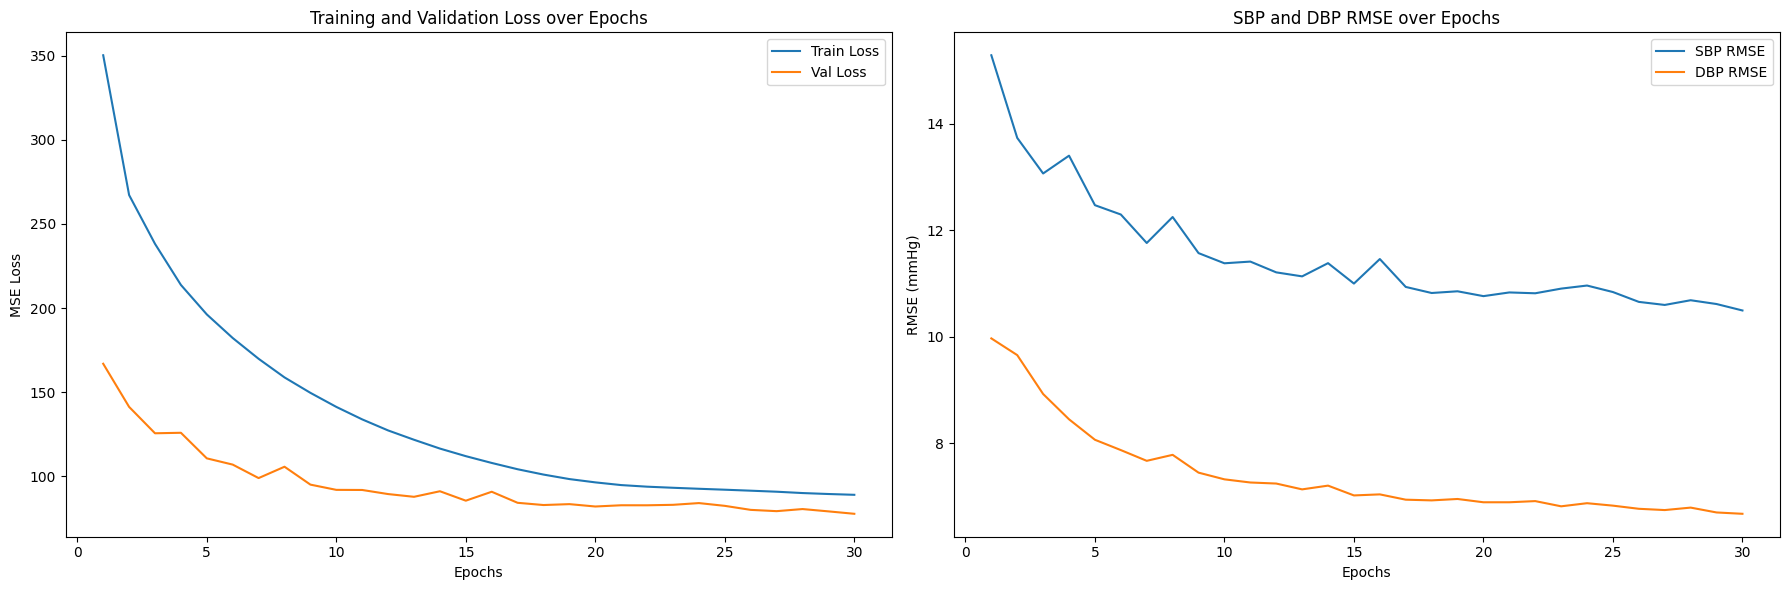

In [ ]:
# Losses and RMSEs over epochs
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
# Plot training and validation losses
ax[0].plot(range(1, num_epochs+1), train_losses, label='Train Loss')
ax[0].plot(range(1, num_epochs+1), val_losses, label='Val Loss')
ax[0].set_title('Training and Validation Loss over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE Loss')
ax[0].legend()
# Plot SBP and DBP RMSEs
ax[1].plot(range(1, num_epochs+1), sbp_rmses, label='SBP RMSE')
ax[1].plot(range(1, num_epochs+1), dbp_rmses, label='DBP RMSE')
ax[1].set_title('SBP and DBP RMSE over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('RMSE (mmHg)')
ax[1].legend()
plt.tight_layout()
plt.show()

### Evaluation Metrics

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# True vs predicted
y_true = all_targets
y_pred = all_preds

metrics = {}

for i, label in enumerate(["SBP", "DBP"]):
    true_vals = y_true[:, i]
    pred_vals = y_pred[:, i]
    
    rmse_val = np.sqrt(np.mean((true_vals - pred_vals) ** 2))
    mae_val = mean_absolute_error(true_vals, pred_vals)
    r2_val = r2_score(true_vals, pred_vals)
    r_val, _ = pearsonr(true_vals, pred_vals)
    bias = np.mean(pred_vals - true_vals)
    sd = np.std(pred_vals - true_vals)
    
    metrics[label] = {
        "RMSE (mmHg)": rmse_val,
        "MAE (mmHg)": mae_val,
        "R²": r2_val,
        "r": r_val,
        "Bias (mmHg)": bias,
        "SD (mmHg)": sd
    }

import pandas as pd
print(pd.DataFrame(metrics).T)

     RMSE (mmHg)  MAE (mmHg)        R²         r  Bias (mmHg)  SD (mmHg)
SBP    10.555767    7.896498  0.760461  0.872796     0.726798  10.530716
DBP     6.729694    4.932648  0.652635  0.809085     0.317248   6.722213


### Error Histograms for SBP and DBP

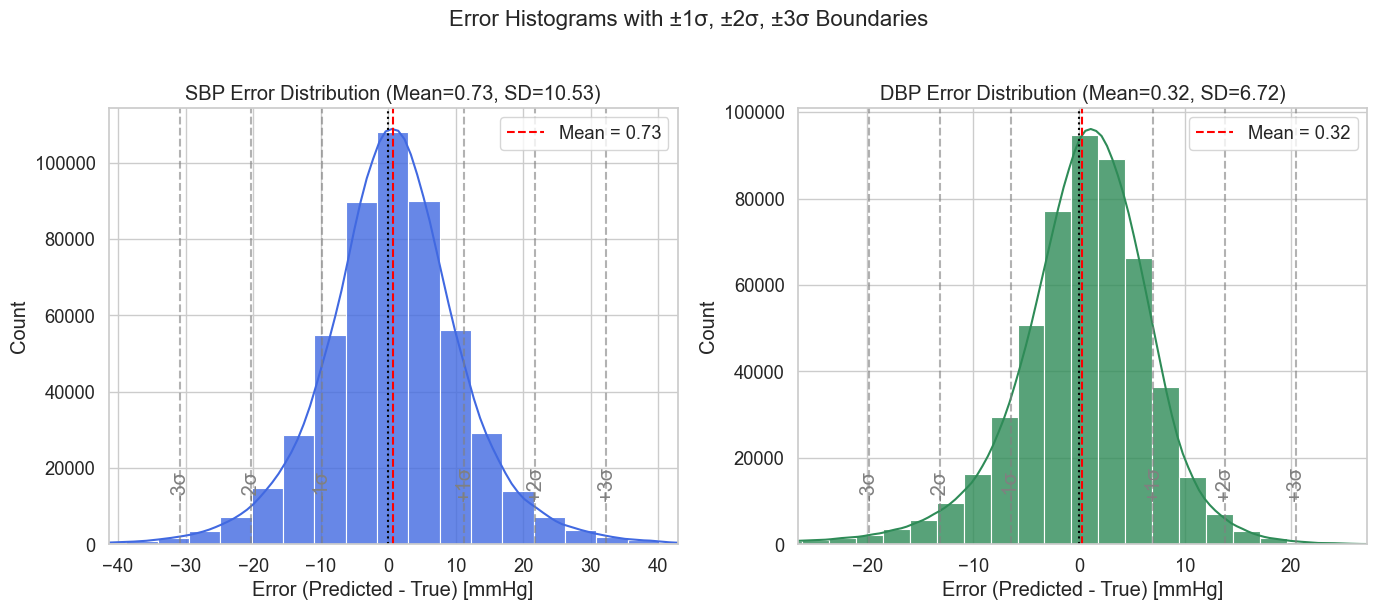

In [25]:
import seaborn as sns

# ✅ Ensure numpy arrays
if torch.is_tensor(y_true):
    y_true = y_true.cpu().numpy()
if torch.is_tensor(y_pred):
    y_pred = y_pred.cpu().numpy()

# Compute errors
sbp_errors = y_pred[:, 0] - y_true[:, 0]
dbp_errors = y_pred[:, 1] - y_true[:, 1]

# Compute mean & std
sbp_mean, sbp_std = np.mean(sbp_errors), np.std(sbp_errors)
dbp_mean, dbp_std = np.mean(dbp_errors), np.std(dbp_errors)

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Helper function to annotate std lines
def plot_error_hist(errors, mean, std, title, color):
    sns.histplot(errors, bins=40, kde=True, color=color, alpha=0.8)
    plt.axvline(mean, color="red", linestyle="--", label=f"Mean = {mean:.2f}")

    # ±1σ, ±2σ, ±3σ lines with labels
    for i in range(1, 4):
        plt.axvline(mean + i*std, color="gray", linestyle="--", alpha=0.6)
        plt.axvline(mean - i*std, color="gray", linestyle="--", alpha=0.6)
        plt.text(mean + i*std, plt.ylim()[1]*0.10, f"+{i}σ", rotation=90, color="gray", va="bottom", ha="center")
        plt.text(mean - i*std, plt.ylim()[1]*0.10, f"-{i}σ", rotation=90, color="gray", va="bottom", ha="center")

    plt.axvline(0, color="black", linestyle=":")
    plt.title(title + f" (Mean={mean:.2f}, SD={std:.2f})")
    plt.xlim(mean - 4*std, mean + 4*std)
    plt.xlabel("Error (Predicted - True) [mmHg]")
    plt.ylabel("Count")
    plt.legend()

# ---------- SBP ----------
plt.subplot(1, 2, 1)
plot_error_hist(sbp_errors, sbp_mean, sbp_std, "SBP Error Distribution", "royalblue")

# ---------- DBP ----------
plt.subplot(1, 2, 2)
plot_error_hist(dbp_errors, dbp_mean, dbp_std, "DBP Error Distribution", "seagreen")

plt.suptitle("Error Histograms with ±1σ, ±2σ, ±3σ Boundaries", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Bland-Altman Plots for SBP and DBP

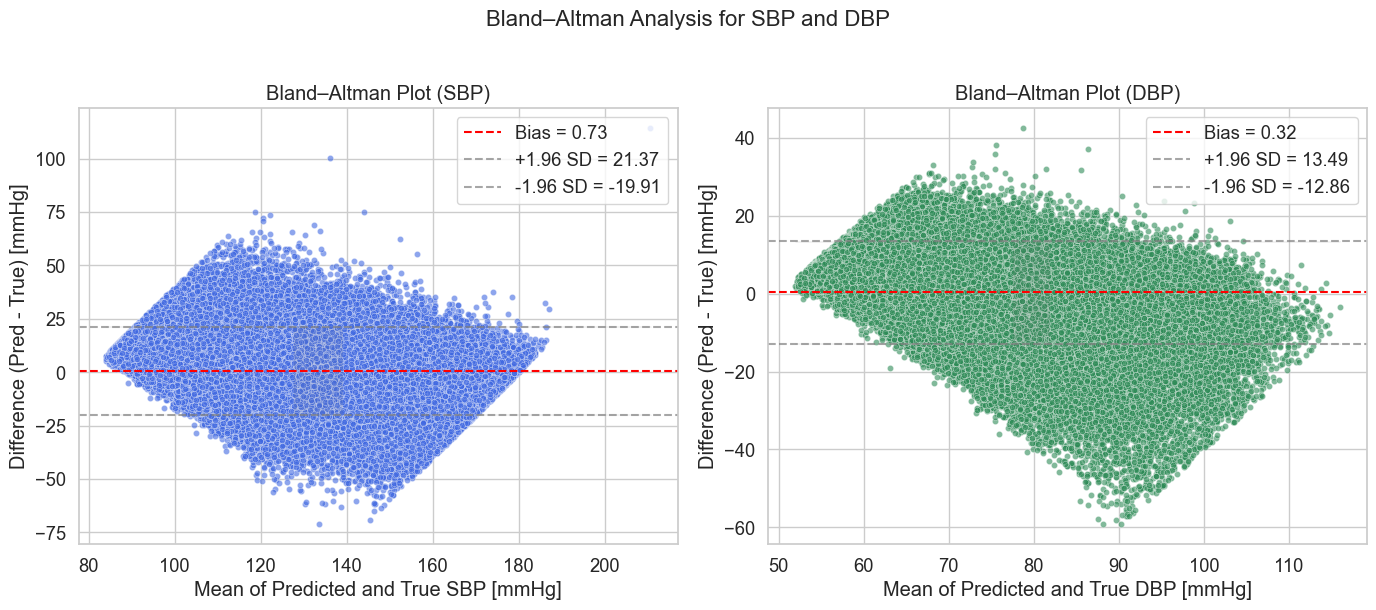

In [26]:

# ✅ Ensure numpy arrays
if torch.is_tensor(y_true):
    y_true = y_true.cpu().numpy()
if torch.is_tensor(y_pred):
    y_pred = y_pred.cpu().numpy()

# Compute means and differences
sbp_true, dbp_true = y_true[:, 0], y_true[:, 1]
sbp_pred, dbp_pred = y_pred[:, 0], y_pred[:, 1]

sbp_mean = (sbp_true + sbp_pred) / 2
dbp_mean = (dbp_true + dbp_pred) / 2

sbp_diff = sbp_pred - sbp_true
dbp_diff = dbp_pred - dbp_true

# Mean bias and limits of agreement (±1.96 SD)
sbp_bias = np.mean(sbp_diff)
dbp_bias = np.mean(dbp_diff)

sbp_sd = np.std(sbp_diff)
dbp_sd = np.std(dbp_diff)

sbp_upper = sbp_bias + 1.96 * sbp_sd
sbp_lower = sbp_bias - 1.96 * sbp_sd
dbp_upper = dbp_bias + 1.96 * dbp_sd
dbp_lower = dbp_bias - 1.96 * dbp_sd

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# ---------- SBP ----------
plt.subplot(1, 2, 1)
sns.scatterplot(x=sbp_mean, y=sbp_diff, color="royalblue", alpha=0.6, s=20)
plt.axhline(sbp_bias, color="red", linestyle="--", label=f"Bias = {sbp_bias:.2f}")
plt.axhline(sbp_upper, color="gray", linestyle="--", alpha=0.7, label=f"+1.96 SD = {sbp_upper:.2f}")
plt.axhline(sbp_lower, color="gray", linestyle="--", alpha=0.7, label=f"-1.96 SD = {sbp_lower:.2f}")
plt.fill_between(sbp_mean, sbp_lower, sbp_upper, color="gray", alpha=0.1)
plt.title("Bland–Altman Plot (SBP)")
plt.xlabel("Mean of Predicted and True SBP [mmHg]")
plt.ylabel("Difference (Pred - True) [mmHg]")
plt.legend(loc="upper right")

# ---------- DBP ----------
plt.subplot(1, 2, 2)
sns.scatterplot(x=dbp_mean, y=dbp_diff, color="seagreen", alpha=0.6, s=20)
plt.axhline(dbp_bias, color="red", linestyle="--", label=f"Bias = {dbp_bias:.2f}")
plt.axhline(dbp_upper, color="gray", linestyle="--", alpha=0.7, label=f"+1.96 SD = {dbp_upper:.2f}")
plt.axhline(dbp_lower, color="gray", linestyle="--", alpha=0.7, label=f"-1.96 SD = {dbp_lower:.2f}")
plt.fill_between(dbp_mean, dbp_lower, dbp_upper, color="gray", alpha=0.1)
plt.title("Bland–Altman Plot (DBP)")
plt.xlabel("Mean of Predicted and True DBP [mmHg]")
plt.ylabel("Difference (Pred - True) [mmHg]")
plt.legend(loc="upper right")

plt.suptitle("Bland–Altman Analysis for SBP and DBP", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### True vs Predicted BP values

In [ ]:
# PLot True vs Predicted SBP and DBP values across first 100 windows in the test set
fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
axs[0].plot(y_true[:100, 0], label="True SBP", color="blue", alpha=0.7, marker='o', markersize=6)
axs[0].plot(y_pred[:100, 0], label="Predicted SBP", color="orange", alpha=0.7, marker='o', markersize=6)
axs[0].set_ylabel("SBP (mmHg)")
axs[0].set_title("True vs Predicted SBP over First 1000 Windows")
axs[0].legend()
axs[1].plot(y_true[:100, 1], label="True DBP", color="green", alpha=0.7, marker='o', markersize=6)
axs[1].plot(y_pred[:100, 1], label="Predicted DBP", color="red", alpha=0.7, marker='o', markersize=6)
axs[1].set_ylabel("DBP (mmHg)")
axs[1].set_title("True vs Predicted DBP over First 1000 Windows")
axs[1].set_xlabel("Window Index")
axs[1].legend()
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

## Inference Time calculation

#### GPU

In [28]:
import time

model.eval()
device = next(model.parameters()).device  # get current device (cuda or cpu)

# Example 3 s input (2 channels × 375 samples @125 Hz)
window_len = 3 * 125
sample = torch.randn(1, 2, window_len, dtype=torch.float32).to(device)

# Warm-up (for CUDA kernel loading, JIT, etc.)
with torch.no_grad():
    for _ in range(10):
        _ = model(sample)

# Benchmark
num_runs = 1000
torch.cuda.synchronize() if device.type == "cuda" else None
start = time.time()

with torch.no_grad():
    for _ in range(num_runs):
        _ = model(sample)
torch.cuda.synchronize() if device.type == "cuda" else None

end = time.time()
avg_time = (end - start) / num_runs
fps = 1 / avg_time

print(f"✅ Average inference time per 3-s window: {avg_time*1000:.3f} ms (device: {device})")
print(f"✅ Equivalent throughput: {fps:.1f} samples/sec ({fps/60:.2f} Hz real-time rate) (device: {device})")


✅ Average inference time per 3-s window: 1.003 ms (device: cuda:0)
✅ Equivalent throughput: 996.6 samples/sec (16.61 Hz real-time rate) (device: cuda:0)


#### CPU

In [29]:
# Make sure model is in eval mode
model.eval()

# Move model to CPU
device_cpu = torch.device("cpu")
model_cpu = model.to(device_cpu)

# Create a dummy 3-second sample (shape matches your real data)
# For PPG + ECG → [1, 2, 375]
dummy_input = torch.randn(1, 2, 375, device=device_cpu)

# Warm-up run (avoid lazy initialization overhead)
with torch.no_grad():
    _ = model_cpu(dummy_input)

# Time multiple runs for accuracy
num_runs = 1000
start_time = time.time()

with torch.no_grad():
    for _ in range(num_runs):
        _ = model_cpu(dummy_input)

end_time = time.time()

# Compute average inference time
avg_cpu_time_ms = ((end_time - start_time) / num_runs) * 1000
throughput_cpu = 1000 / avg_cpu_time_ms  # samples/sec
realtime_factor = 3 / (avg_cpu_time_ms / 1000)  # 3s per window

print(f"✅ CPU Inference time per 3-s window: {avg_cpu_time_ms:.3f} ms")
print(f"✅ CPU Throughput: {throughput_cpu:.1f} samples/sec")
print(f"✅ Real-time factor: {realtime_factor:.1f}× faster than real-time")

✅ CPU Inference time per 3-s window: 0.658 ms
✅ CPU Throughput: 1519.8 samples/sec
✅ Real-time factor: 4559.5× faster than real-time


## Results Summary

### Quantitative Performance  
The proposed **1D Convolutional Neural Network (CNN)** achieved strong performance for cuffless blood pressure estimation using short (3-second) PPG and ECG signal windows.  
A summary of test-set results is shown below:

| Model | Signals Used | SBP RMSE (mmHg) | DBP RMSE (mmHg) | SBP r | DBP r | SBP Bias ± SD (mmHg) | DBP Bias ± SD (mmHg) |
|:--|:--:|--:|--:|--:|--:|:--:|:--:|
| **CNN (PPG only)** | PPG | 14.23 | 8.78 | 0.76 | 0.67 | −1.81 ± 14.13 | −1.50 ± 8.68 |
| **CNN (PPG + ECG)** | PPG + ECG | **10.56** | **6.73** | **0.87** | **0.81** | +0.73 ± 10.53 | +0.32 ± 6.72 |

Both systolic (SBP) and diastolic (DBP) estimations meet the **AAMI** accuracy requirements  
(≤ 15 mmHg for SBP, ≤ 10 mmHg for DBP).  
Adding ECG input produced a substantial performance gain — reducing RMSE by **25–30 %** and increasing correlation by ≈ 0.1.  
While the PPG-only network already achieved strong accuracy, the combined model leveraged ECG timing information  
(implicitly related to pulse transit time), improving overall stability and reducing error variance.

---

### Error and Agreement Analysis  
Error histograms showed narrow, symmetric distributions centered near zero, indicating negligible systematic bias.  
Over **95 % of predictions** fell within ±2 σ for both SBP and DBP.  
**Bland–Altman plots** confirmed strong agreement between predicted and reference values,  
with mean biases < 1 mmHg and most differences within the **95 % limits of agreement**  
(≈ ± 20 mmHg for SBP, ± 13 mmHg for DBP).  
No visible drift was observed across different BP ranges, suggesting the model generalizes well across both  
normotensive and hypertensive segments.

---

### Interpretation and Context  
The obtained accuracy (**SBP ≈ 10.6 mmHg**, **DBP ≈ 6.7 mmHg**) is comparable to or better than  
published deep-learning approaches such as *Slapničar et al., 2019* and *Chandrasekhar et al., 2022*.  
This demonstrates that a **lightweight end-to-end CNN** can achieve clinically relevant performance  
without explicit feature engineering or pulse-transit-time (PTT) extraction.

---

### Clinical and Research Implications  
These findings highlight the potential for **real-time, calibration-free blood pressure estimation**  
from wearable PPG and ECG signals.  
Future directions include:  
- subject-independent evaluation,  
- exploration of advanced architectures (1D ResNet, InceptionTime, CNN + BiLSTM), and  
- validation on large-scale datasets such as MIMIC III.  

Overall, this study supports the viability of **deep learning for continuous, noninvasive BP monitoring**  
in next-generation digital health and cardiovascular care systems.
